Fonte dos dados: https://butantan.gov.br/

O objetivo desse trabalho é fazer previsões sobre a classificação final quanto ao teste de covid-19 de um indivíduo com 2 doses de vacina contra covid-19 com base nas informações sobre ele disponíveis.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# 1. Preparação dos dados

In [2]:
# Lê todos os arquivos csv

files = os.listdir('butantan_2022_csv')
dfs = []
for file in files:
    dfs.append(pd.read_csv(f'butantan_2022_csv/{file}'))

C:\Users\jldui\AppData\Local\Temp\ipykernel_62808\747726872.py:4: DtypeWarning: Columns (15,28,30,34,35,57,62) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(f'butantan_2022_csv/{file}'))
C:\Users\jldui\AppData\Local\Temp\ipykernel_62808\747726872.py:4: DtypeWarning: Columns (15,30,34,62) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(f'butantan_2022_csv/{file}'))
C:\Users\jldui\AppData\Local\Temp\ipykernel_62808\747726872.py:4: DtypeWarning: Columns (15,28,30,34,35,62) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(f'butantan_2022_csv/{file}'))
C:\Users\jldui\AppData\Local\Temp\ipykernel_62808\747726872.py:4: DtypeWarning: Columns (15,20,21,22,25,30,31,33,45,46,57,62) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(f'butantan_2022_csv/{file}'))
C:\Users\jldui\AppData\Local\Temp\ipy

In [3]:
# reduz cada dataframe para as colunas que interessam

for df in dfs:
   cols = ['dataNotificacao', 'dataInicioSintomas', 'sintomas', 'outrosSintomas', 'outrasCondicoes', 'cbo', 'condicoes', 'estado', 'codigoRecebeuVacina',
      'estadoIBGE', 'municipio', 'municipioIBGE', 'origem', 'estadoNotificacao', 'estadoNotificacaoIBGE', 'municipioNotificacao', 'municipioNotificacaoIBGE',
      'excluido', 'validado', 'evolucaoCaso', 'codigoEstrategiaCovid', 'codigoBuscaAtivaAssintomatico', 'outroBuscaAtivaAssintomatico',
      'codigoTriagemPopulacaoEspecifica', 'outroTriagemPopulacaoEspecifica', 'codigoLocalRealizacaoTestagem', 'outroLocalRealizacaoTestagem', 'lotePrimeiraDose',
      'loteSegundaDose', 'codigoContemComunidadeTradicional', 'totalTestesRealizados', 'codigoEstadoTeste1', 'codigoTipoTeste1', 'codigoFabricanteTeste1',
      'codigoResultadoTeste1', 'dataColetaTeste1', 'codigoEstadoTeste2', 'codigoTipoTeste2', 'codigoFabricanteTeste2', 'codigoResultadoTeste2', 'dataColetaTeste2',
      'codigoEstadoTeste3', 'codigoTipoTeste3', 'codigoFabricanteTeste3', 'codigoResultadoTeste3', 'dataColetaTeste3', 'codigoEstadoTeste4', 'codigoTipoTeste4',
      'codigoFabricanteTeste4', 'codigoResultadoTeste4', 'dataColetaTeste4', 'Unnamed: 64', 'Unnamed: 65', 'Unnamed: 66', 'Unnamed: 67', 'Unnamed: 68', 'source_id',
      'Unnamed: 69', 'Unnamed: 70', 'Unnamed: 71', 'Unnamed: 72', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'codigoDosesVacina']
   df.drop(columns=[col for col in cols if col in df.columns], inplace=True)

In [4]:
# concatena os dataframes

data = pd.concat(dfs, ignore_index=True, verify_integrity=True)

In [5]:
data

,profissionalSaude,racaCor,profissionalSeguranca,sexo,dataEncerramento,classificacaoFinal,dataPrimeiraDose,dataSegundaDose,codigoLaboratorioPrimeiraDose,codigoLaboratorioSegundaDose,idade
0,NÃ£o,Parda,NÃ£o,Feminino,05-10-22,Descartado,07-22-21,NaN,ASTRAZENECA/FIOCRUZ,NaN,43.0
1,NÃ£o,Parda,NÃ£o,Feminino,07-27-22,Descartado,05-14-21,08-11-21,ASTRAZENECA/FIOCRUZ,ASTRAZENECA/FIOCRUZ,49.0
2,NÃ£o,Parda,NÃ£o,Feminino,04-22-22,Descartado,07-22-21,10-21-21,ASTRAZENECA/FIOCRUZ,ASTRAZENECA/FIOCRUZ,37.0
3,NÃ£o,Ignorado,NÃ£o,Feminino,07-19-22,Confirmado Laboratorial,05-14-21,NaN,ASTRAZENECA,NaN,52.0
4,NÃ£o,Parda,NÃ£o,Masculino,05-31-22,Confirmado Laboratorial,07-22-21,10-04-21,ASTRAZENECA/FIOCRUZ,ASTRAZENECA/FIOCRUZ,35.0
...,...,...,...,...,...,...,...,...,...,...,...
41980476,NÃ£o,Parda,NÃ£o,Feminino,12-21-21,Descartado,NaN,05-06-21,NaN,SINOVAC/BUTANTAN,71.0
41980477,NÃ£o,Ignorado,NÃ£o,Feminino,12-25-21,Descartado,NaN,11-30-21,PFIZER,PFIZER,31.0
41980478,NÃ£o,Parda,NÃ£o,Masculino,NaN,NaN,NaN,10-06-21,NaN,ASTRAZENECA/FIOCRUZ,52.0
41980479,NÃ£o,Parda,NÃ£o,Feminino,NaN,Descartado,NaN,11-30-21,NaN,PFIZER,34.0


In [6]:
data.head()

,profissionalSaude,racaCor,profissionalSeguranca,sexo,dataEncerramento,classificacaoFinal,dataPrimeiraDose,dataSegundaDose,codigoLaboratorioPrimeiraDose,codigoLaboratorioSegundaDose,idade
0,NÃ£o,Parda,NÃ£o,Feminino,05-10-22,Descartado,07-22-21,NaN,ASTRAZENECA/FIOCRUZ,NaN,43.0
1,NÃ£o,Parda,NÃ£o,Feminino,07-27-22,Descartado,05-14-21,08-11-21,ASTRAZENECA/FIOCRUZ,ASTRAZENECA/FIOCRUZ,49.0
2,NÃ£o,Parda,NÃ£o,Feminino,04-22-22,Descartado,07-22-21,10-21-21,ASTRAZENECA/FIOCRUZ,ASTRAZENECA/FIOCRUZ,37.0
3,NÃ£o,Ignorado,NÃ£o,Feminino,07-19-22,Confirmado Laboratorial,05-14-21,NaN,ASTRAZENECA,NaN,52.0
4,NÃ£o,Parda,NÃ£o,Masculino,05-31-22,Confirmado Laboratorial,07-22-21,10-04-21,ASTRAZENECA/FIOCRUZ,ASTRAZENECA/FIOCRUZ,35.0


In [7]:
data.tail()

,profissionalSaude,racaCor,profissionalSeguranca,sexo,dataEncerramento,classificacaoFinal,dataPrimeiraDose,dataSegundaDose,codigoLaboratorioPrimeiraDose,codigoLaboratorioSegundaDose,idade
41980476,NÃ£o,Parda,NÃ£o,Feminino,12-21-21,Descartado,NaN,05-06-21,NaN,SINOVAC/BUTANTAN,71.0
41980477,NÃ£o,Ignorado,NÃ£o,Feminino,12-25-21,Descartado,NaN,11-30-21,PFIZER,PFIZER,31.0
41980478,NÃ£o,Parda,NÃ£o,Masculino,NaN,NaN,NaN,10-06-21,NaN,ASTRAZENECA/FIOCRUZ,52.0
41980479,NÃ£o,Parda,NÃ£o,Feminino,NaN,Descartado,NaN,11-30-21,NaN,PFIZER,34.0
41980480,NÃ£o,Parda,NÃ£o,Feminino,NaN,NaN,NaN,11-08-21,NaN,ASTRAZENECA/FIOCRUZ,29.0


In [8]:
data.sample(n=15)

,profissionalSaude,racaCor,profissionalSeguranca,sexo,dataEncerramento,classificacaoFinal,dataPrimeiraDose,dataSegundaDose,codigoLaboratorioPrimeiraDose,codigoLaboratorioSegundaDose,idade
24971378,NÃ£o,Ignorado,NÃ£o,Feminino,NaN,SÃ­ndrome Gripal NÃ£o Especificada,07-06-21,11-09-21,PFIZER,PFIZER,48.0
30310935,NÃ£o,Ignorado,NÃ£o,Masculino,01-22-22,SÃ­ndrome Gripal NÃ£o Especificada,NaN,10-14-21,NaN,PFIZER,23.0
9207071,NÃ£o,Branca,NÃ£o,Feminino,06-20-22,Confirmado Laboratorial,NaN,NaN,NaN,NaN,52.0
29556608,NÃ£o,Parda,NÃ£o,Feminino,NaN,NaN,07-05-21,NaN,PFIZER,NaN,42.0
33939929,NÃ£o,Branca,NÃ£o,Feminino,01-11-22,Descartado,NaN,NaN,NaN,NaN,64.0
18209836,NÃ£o,Parda,NÃ£o,Masculino,NaN,NaN,NaN,NaN,NaN,NaN,28.0
13726185,NÃ£o,Parda,NÃ£o,Feminino,NaN,NaN,NaN,NaN,NaN,NaN,28.0
37287855,NÃ£o,Preta,NÃ£o,Feminino,12-31-21,SÃ­ndrome Gripal NÃ£o Especificada,NaN,NaN,NaN,SINOVAC/BUTANTAN,37.0
15905341,NÃ£o,Branca,NÃ£o,Masculino,07-08-22,Descartado,04-19-21,07-12-21,ASTRAZENECA/FIOCRUZ,ASTRAZENECA/FIOCRUZ,67.0
40386750,NÃ£o,Branca,NÃ£o,Feminino,02-08-22,Confirmado por CritÃ©rio ClÃ­nico,06-18-21,NaN,ASTRAZENECA/FIOCRUZ,ASTRAZENECA/FIOCRUZ,56.0


In [9]:
data.shape

(41980481, 11)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41980481 entries, 0 to 41980480
Data columns (total 11 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   profissionalSaude              object 
 1   racaCor                        object 
 2   profissionalSeguranca          object 
 3   sexo                           object 
 4   dataEncerramento               object 
 5   classificacaoFinal             object 
 6   dataPrimeiraDose               object 
 7   dataSegundaDose                object 
 8   codigoLaboratorioPrimeiraDose  object 
 9   codigoLaboratorioSegundaDose   object 
 10  idade                          float64
dtypes: float64(1), object(10)
memory usage: 3.4+ GB


In [11]:
data.columns

Index(['profissionalSaude', 'racaCor', 'profissionalSeguranca', 'sexo',
       'dataEncerramento', 'classificacaoFinal', 'dataPrimeiraDose',
       'dataSegundaDose', 'codigoLaboratorioPrimeiraDose',
       'codigoLaboratorioSegundaDose', 'idade'],
      dtype='object')

In [12]:
data.dtypes

profissionalSaude                 object
racaCor                           object
profissionalSeguranca             object
sexo                              object
dataEncerramento                  object
classificacaoFinal                object
dataPrimeiraDose                  object
dataSegundaDose                   object
codigoLaboratorioPrimeiraDose     object
codigoLaboratorioSegundaDose      object
idade                            float64
dtype: object

In [13]:
data.describe(include = 'all')

,profissionalSaude,racaCor,profissionalSeguranca,sexo,dataEncerramento,classificacaoFinal,dataPrimeiraDose,dataSegundaDose,codigoLaboratorioPrimeiraDose,codigoLaboratorioSegundaDose,idade
count,41976294,41936016,41933754,41971581,17340145,18357321,27364737,24060407,28077368,25405220,4.197099e+07
unique,2,8,24,26,2463,15,805,761,166,158,NaN
top,NÃ£o,Branca,NÃ£o,Feminino,02-10-22,Confirmado Laboratorial,08-10-21,09-08-21,ASTRAZENECA/FIOCRUZ,ASTRAZENECA/FIOCRUZ,NaN
freq,41216650,15290378,41834749,24312198,162814,7878954,311202,329412,10248512,8909477,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.766599e+01
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.937450e+01
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.179000e+03
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.400000e+01
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.600000e+01
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000e+01


# 2. Limpeza dos dados

In [14]:
data.isnull().sum()

profissionalSaude                    4187
racaCor                             44465
profissionalSeguranca               46727
sexo                                 8900
dataEncerramento                 24640336
classificacaoFinal               23623160
dataPrimeiraDose                 14615744
dataSegundaDose                  17920074
codigoLaboratorioPrimeiraDose    13903113
codigoLaboratorioSegundaDose     16575261
idade                                9492
dtype: int64

In [15]:
# retirando dados faltantes porque ainda sobra um volume enorme de dados

data.dropna(inplace = True)

In [16]:
# uniformizando os nomes das vacinas

grupos_vacinas = {}

for vacina in [data['codigoLaboratorioPrimeiraDose'].unique(), data['codigoLaboratorioSegundaDose'].unique()]:
    # Iterar sobre as vacinas
    for vacina_string in vacina:
        # Obter o nome da vacina
        if "pfizer" in vacina_string.lower():
            nome_vacina = "Pfizer"
        elif "astrazeneca" in vacina_string.lower():
            nome_vacina = "AstraZeneca"
        elif "sinovac" in vacina_string.lower() or "coronavac" in vacina_string.lower():
            nome_vacina = "Sinovac/Coronavac"
        else:
            nome_vacina = "Outra Vacina"
        
        # Verificar se a vacina já está no dicionário
        if nome_vacina in grupos_vacinas:
            grupos_vacinas[nome_vacina].append(vacina_string)
        else:
            grupos_vacinas[nome_vacina] = [vacina_string]

In [17]:
for vacina in ['FUNDAÃ‡ÃƒO OSWALDO CRUZ', 'OXFORD/ASTRA ZENECA', 'ATRAZENECA/FIOCRUZ', 'FUNDACAO OSWALDO CRUZ', 'Covid-19-Covishield-Oxford/Fiocruz', 'SERUM INSTITUTE OF INDIA LTD', 'FIOCRUZ - FUNDACAO OSWALDO CRUZ', 'OXFORD / ASTRA ZENECA', 'Covid-19 - Covishield', 'COVID-19-COVISHIELD-OXFORD/FIOCRUZ', 'ASTRA ZENECA', 'SERUM INSTITUTE OF INDIA LTD.', 'Vacina Covid-19 - Covishield', 'Covid-19 - ChAdOx1 nCoV-19', 'UNIVERSITY OF OXFORD', 'FUNDACAO OSWALDO CRUZ', 'Covid-19-Covishield-Oxford/Fiocruz', 'SERUM INSTITUTE OF INDIA LTD', 'FIOCRUZ - FUNDACAO OSWALDO CRUZ', 'OXFORD / ASTRA ZENECA', 'Covid-19 - Covishield', 'COVID-19-COVISHIELD-OXFORD/FIOCRUZ', 'ASTRA ZENECA', 'SERUM INSTITUTE OF INDIA LTD.', 'Vacina Covid-19 - Covishield', 'Covid-19 - ChAdOx1 nCoV-19', 'UNIVERSITY OF OXFORD']:
    grupos_vacinas['AstraZeneca'].append(vacina)

for vacina in ['BIONTECH', 'BIONTECH']:
    grupos_vacinas['Pfizer'].append(vacina)

for vacina in ['Butantan', 'FUNDACAO BUTANTAN', 'BUTANTAN - FUNDACAO BUTANTAN', 'INSTITUTO BUTANTAN', 'BUTANTAN', 'FUNDACAO BUTANTAN', 'BUTANTAN - FUNDACAO BUTANTAN', 'INSTITUTO BUTANTAN', 'BUTANTAN']:
    grupos_vacinas['Sinovac/Coronavac'].append(vacina)

AstraZeneca = grupos_vacinas['AstraZeneca']
Pfizer = grupos_vacinas['Pfizer']
Coronavac = grupos_vacinas['Sinovac/Coronavac']
lixo = ['JANSSEN', 'JANSSEN', 'JANSSEN-CILAG', 'JOHNSON & JOHNSON/JANSSEN', 'MINISTERIO DA SAUDE', 'Pendente IdentificaÃ§Ã£o', 'Pendente Identifica??o', 'Organization/', 'WYETH PHARMACEUTICALS', 'Display of Organization/33781055006761', 'Display of Organization/61189445000156', 'SANOFI PASTEUR', 'MINISTERIO DA SAUDE', 'Pendente IdentificaÃ§Ã£o', 'Pendente Identifica??o', 'Organization/', 'WYETH PHARMACEUTICALS', 'Display of Organization/33781055006761', 'Display of Organization/61189445000156', 'SANOFI PASTEUR']

In [18]:
data.replace(to_replace='NÃ£o', value='Não', inplace=True)
data.replace(to_replace='SÃ\xadndrome Gripal NÃ£o Especificada', value='Descartado', inplace=True)
data.replace(to_replace='Confirmado ClÃ\xadnico-EpidemiolÃ³gico', value='Confirmado', inplace=True)
data.replace(to_replace='Confirmado Laboratorial', value='Confirmado', inplace=True)
data.replace(to_replace='Confirmado por CritÃ©rio ClÃ\xadnico', value='Confirmado', inplace=True)
data.replace(to_replace='Confirmado ClÃ\xadnico-Imagem', value='Confirmado', inplace=True)

for vacina in AstraZeneca:
    data.replace(to_replace=vacina, value='AstraZeneca', inplace=True)

for vacina in Pfizer:
    data.replace(to_replace=vacina, value='Pfizer', inplace=True)

for vacina in Coronavac:
    data.replace(to_replace=vacina, value='Coronavac', inplace=True)

for vacina in lixo:
    data.replace(to_replace=vacina, value=np.nan, inplace=True)

In [19]:
# Colocando em formato de data

data.replace(r"(\d{2}-\d{2})-(\d{2})", r"\1-20\2", regex=True, inplace=True)

In [20]:
data['dataSegundaDose'] = pd.to_datetime(data['dataSegundaDose'], format='%m-%d-%Y')
data['dataPrimeiraDose'] = pd.to_datetime(data['dataPrimeiraDose'], format='%m-%d-%Y')
data['dataEncerramento'] = pd.to_datetime(data['dataEncerramento'], format='%m-%d-%Y')

In [21]:
# Adiciona colunas de dias entre as doses e dias entre a primeira/segunda dose e o encerramento

data['diasEntreDoses'] = (data['dataSegundaDose'] - data['dataPrimeiraDose']).dt.days
data['diasEntrePrimeiraDoseEncerramento'] = (data['dataEncerramento'] - data['dataPrimeiraDose']).dt.days
data['diasEntreSegundaDoseEncerramento'] = (data['dataEncerramento'] - data['dataSegundaDose']).dt.days

In [22]:
# Haviam muitas idades absurdas, então vamos remover os registros com idade maior que 122 (idade da pessoa mais velha do mundo)

data.drop(data[data['idade'] > 122].index, inplace=True)

In [23]:
data.isnull().sum()

profissionalSaude                        0
racaCor                                  0
profissionalSeguranca                    0
sexo                                     0
dataEncerramento                         0
classificacaoFinal                       0
dataPrimeiraDose                         0
dataSegundaDose                          0
codigoLaboratorioPrimeiraDose        54564
codigoLaboratorioSegundaDose         58520
idade                                    0
diasEntreDoses                           0
diasEntrePrimeiraDoseEncerramento        0
diasEntreSegundaDoseEncerramento         0
dtype: int64

In [24]:
# Removendo registros de vacinas não identificadas ou diferentes de AstraZeneca, Pfizer e Coronavac

data.dropna(inplace = True)

In [25]:
for column in data.columns:
   print(f'{column}: {data[column].unique()}')

profissionalSaude: ['Não' 'Sim']
racaCor: ['Parda' 'Ignorado' 'Amarela' 'Branca' 'Preta' 'Indigena']
profissionalSeguranca: ['Não' 'Sim']
sexo: ['Feminino' 'Masculino' 'Indefinido']
dataEncerramento: ['2022-07-27T00:00:00.000000000' '2022-04-22T00:00:00.000000000'
 '2022-05-31T00:00:00.000000000' ... '2094-05-05T00:00:00.000000000'
 '2099-10-11T00:00:00.000000000' '2092-10-14T00:00:00.000000000']
classificacaoFinal: ['Descartado' 'Confirmado']
dataPrimeiraDose: ['2021-05-14T00:00:00.000000000' '2021-07-22T00:00:00.000000000'
 '2021-07-23T00:00:00.000000000' '2021-05-15T00:00:00.000000000'
 '2021-07-24T00:00:00.000000000' '2021-07-25T00:00:00.000000000'
 '2021-07-26T00:00:00.000000000' '2021-05-16T00:00:00.000000000'
 '2021-07-27T00:00:00.000000000' '2021-07-28T00:00:00.000000000'
 '2021-05-17T00:00:00.000000000' '2021-07-29T00:00:00.000000000'
 '2021-05-18T00:00:00.000000000' '2021-07-30T00:00:00.000000000'
 '2021-05-19T00:00:00.000000000' '2021-07-31T00:00:00.000000000'
 '2021-05-20T0

In [29]:
data.drop(columns=['dataPrimeiraDose', 'dataSegundaDose', 'dataEncerramento'], inplace=True)

In [30]:
data.to_csv('data.csv', index=False)

# 3. Visualizações

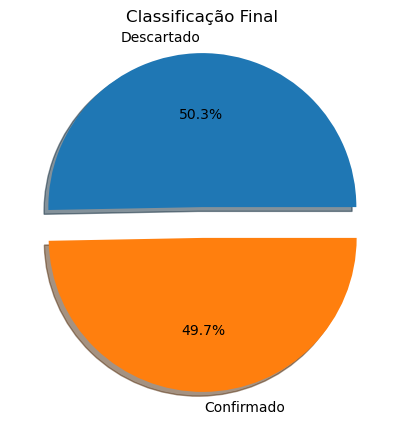

In [31]:
fig, ax = plt.subplots(figsize=(5, 5))
data['classificacaoFinal'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax, shadow=True, explode=(0.1, 0.1))
ax.set_title('Classificação Final')
ax.set_ylabel('')
plt.show()

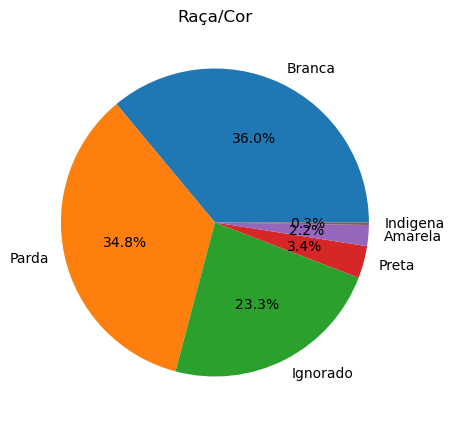

In [32]:
fig, ax = plt.subplots(figsize=(5, 5))
data['racaCor'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax)
ax.set_title('Raça/Cor')
ax.set_ylabel('')
plt.show()

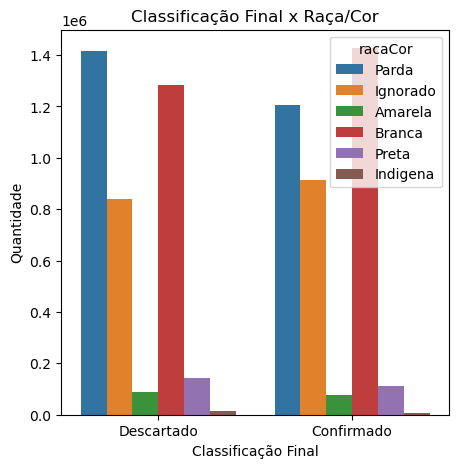

In [33]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(x='classificacaoFinal', hue='racaCor', data=data, ax=ax)
ax.set_title('Classificação Final x Raça/Cor')
ax.set_xlabel('Classificação Final')
ax.set_ylabel('Quantidade')
plt.show()

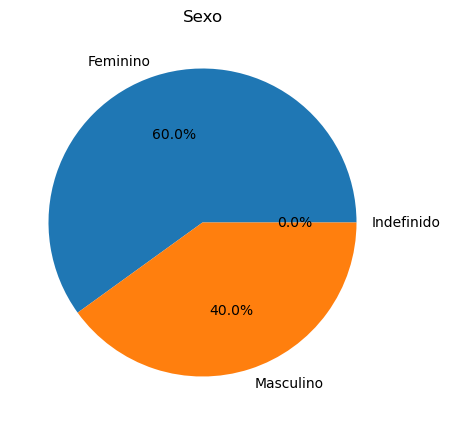

In [34]:
fig, ax = plt.subplots(figsize=(5, 5))
data['sexo'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax)
ax.set_title('Sexo')
ax.set_ylabel('')
plt.show()

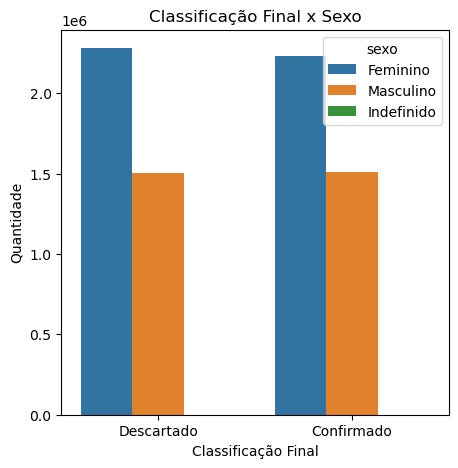

In [35]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(x='classificacaoFinal', hue='sexo', data=data, ax=ax)
ax.set_title('Classificação Final x Sexo')
ax.set_xlabel('Classificação Final')
ax.set_ylabel('Quantidade')
plt.show()

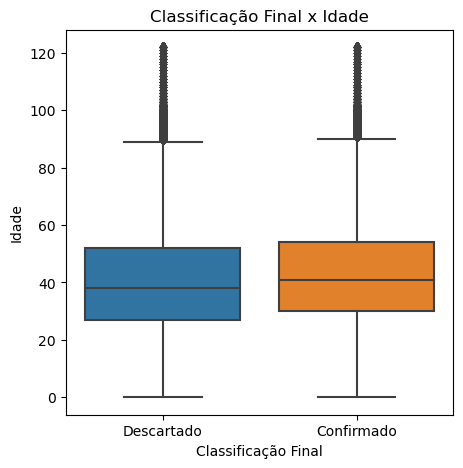

In [36]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(x='classificacaoFinal', y='idade', data=data, ax=ax)
ax.set_title('Classificação Final x Idade')
ax.set_xlabel('Classificação Final')
ax.set_ylabel('Idade')
plt.show()

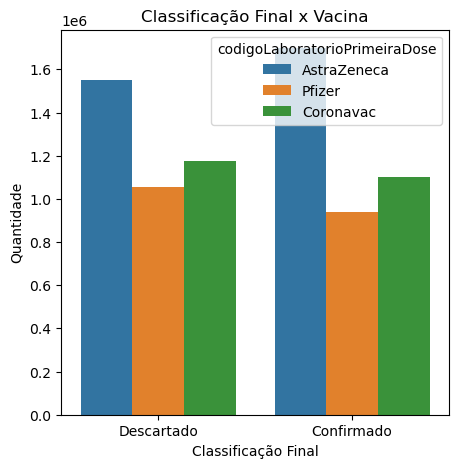

In [37]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(x='classificacaoFinal', hue='codigoLaboratorioPrimeiraDose', data=data, ax=ax)
ax.set_title('Classificação Final x Vacina')
ax.set_xlabel('Classificação Final')
ax.set_ylabel('Quantidade')
plt.show()

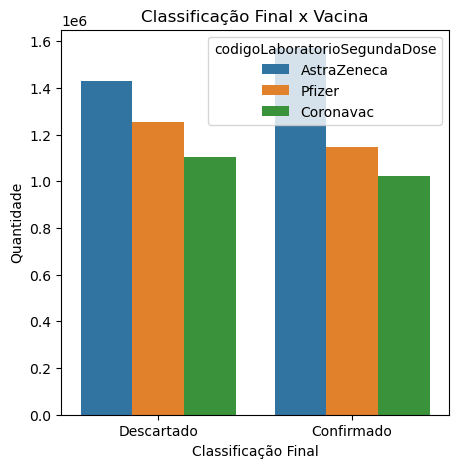

In [38]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(x='classificacaoFinal', hue='codigoLaboratorioSegundaDose', data=data, ax=ax)
ax.set_title('Classificação Final x Vacina')
ax.set_xlabel('Classificação Final')
ax.set_ylabel('Quantidade')
plt.show()

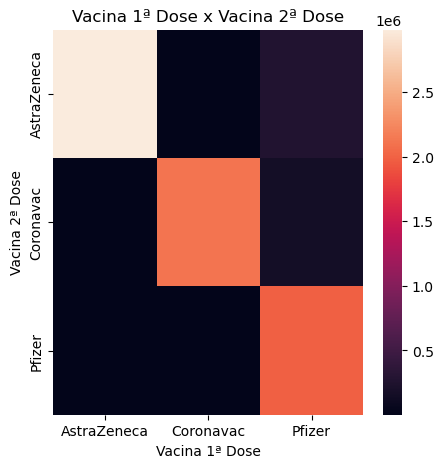

In [39]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(pd.crosstab(data['codigoLaboratorioPrimeiraDose'], data['codigoLaboratorioSegundaDose']), ax=ax)
ax.set_title('Vacina 1ª Dose x Vacina 2ª Dose')
ax.set_xlabel('Vacina 1ª Dose')
ax.set_ylabel('Vacina 2ª Dose')
plt.show()


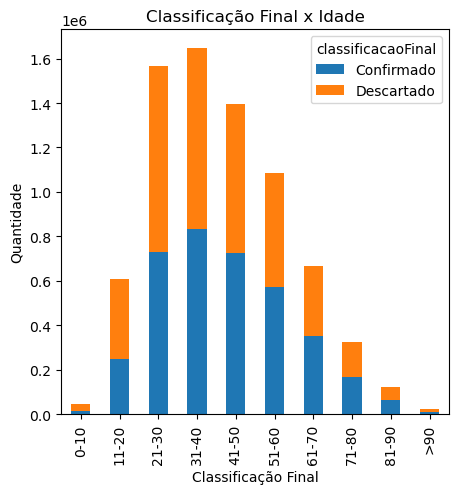

In [40]:
data['idadeAgrupada'] = pd.cut(data['idade'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 122], labels=['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '>90'])
fig, ax = plt.subplots(figsize=(5, 5))
data.groupby(['idadeAgrupada', 'classificacaoFinal']).size().unstack().plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Classificação Final x Idade')
ax.set_xlabel('Classificação Final')
ax.set_ylabel('Quantidade')
plt.show()
data.drop(columns=['idadeAgrupada'], inplace=True)

# 4. Feature Engineering

In [2]:
data = pd.read_csv('data.csv')

In [3]:
# One Hot Encoding

categorical_features = ['sexo', 'racaCor', 'profissionalSaude', 'profissionalSeguranca', 'codigoLaboratorioPrimeiraDose', 'codigoLaboratorioSegundaDose']
numerical_features = ['idade', 'diasEntreDoses']
target = ['classificacaoFinal']

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder.fit(data[categorical_features])
encoded_cols = list(encoder.get_feature_names_out(categorical_features))
data[encoded_cols] = encoder.transform(data[categorical_features])

In [4]:
data['classificacaoFinal'] = data['classificacaoFinal'].apply(lambda x: 1 if x == 'Confirmado' else 0)

In [5]:
data.drop(columns=categorical_features, inplace=True)

In [6]:
data

,classificacaoFinal,idade,diasEntreDoses,diasEntrePrimeiraDoseEncerramento,diasEntreSegundaDoseEncerramento,sexo_Feminino,sexo_Indefinido,sexo_Masculino,racaCor_Amarela,racaCor_Branca,...,profissionalSaude_Não,profissionalSaude_Sim,profissionalSeguranca_Não,profissionalSeguranca_Sim,codigoLaboratorioPrimeiraDose_AstraZeneca,codigoLaboratorioPrimeiraDose_Coronavac,codigoLaboratorioPrimeiraDose_Pfizer,codigoLaboratorioSegundaDose_AstraZeneca,codigoLaboratorioSegundaDose_Coronavac,codigoLaboratorioSegundaDose_Pfizer
0,0,49.0,89,439,350,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0,37.0,91,274,183,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1,35.0,74,313,239,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0,31.0,95,399,304,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0,40.0,97,280,183,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7523227,1,11.0,49,98,49,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7523228,1,8.0,49,91,42,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7523229,1,10.0,32,53,21,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7523230,1,8.0,37,49,12,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [8]:
# Separando os dados em treino e teste

X_train, X_test, y_train, y_test = train_test_split(data.drop(labels = ['classificacaoFinal'], axis = 1),
                                                    data['classificacaoFinal'],
                                                    test_size = 0.3,
                                                    random_state = 42)

X_train.shape, X_test.shape

((5266262, 23), (2256970, 23))

In [89]:
# Por Lasso, podemos ver que todos os coeficientes são muito pequenos, o que significa que eles não contribuem muito para a previsão.

features = data.drop('classificacaoFinal', axis=1)
target = data['classificacaoFinal']
lasso = Lasso(alpha=0.1) 
lasso.fit(features, target)
feature_coeffs = pd.DataFrame({'Feature': features.columns, 'Coefficient': lasso.coef_})
feature_coeffs['Absolute Coefficient'] = feature_coeffs['Coefficient'].abs()
feature_coeffs = feature_coeffs.sort_values(by='Absolute Coefficient', ascending=False)
print(feature_coeffs)

                                      Feature  Coefficient  \
0                                       idade     0.001385   
1                              diasEntreDoses     0.000152   
3            diasEntreSegundaDoseEncerramento    -0.000025   
13                      profissionalSaude_Não    -0.000000   
21     codigoLaboratorioSegundaDose_Coronavac    -0.000000   
20   codigoLaboratorioSegundaDose_AstraZeneca     0.000000   
19       codigoLaboratorioPrimeiraDose_Pfizer    -0.000000   
18    codigoLaboratorioPrimeiraDose_Coronavac    -0.000000   
17  codigoLaboratorioPrimeiraDose_AstraZeneca     0.000000   
16                  profissionalSeguranca_Sim     0.000000   
15                  profissionalSeguranca_Não    -0.000000   
14                      profissionalSaude_Sim     0.000000   
11                              racaCor_Parda    -0.000000   
12                              racaCor_Preta    -0.000000   
10                           racaCor_Indigena    -0.000000   
9       

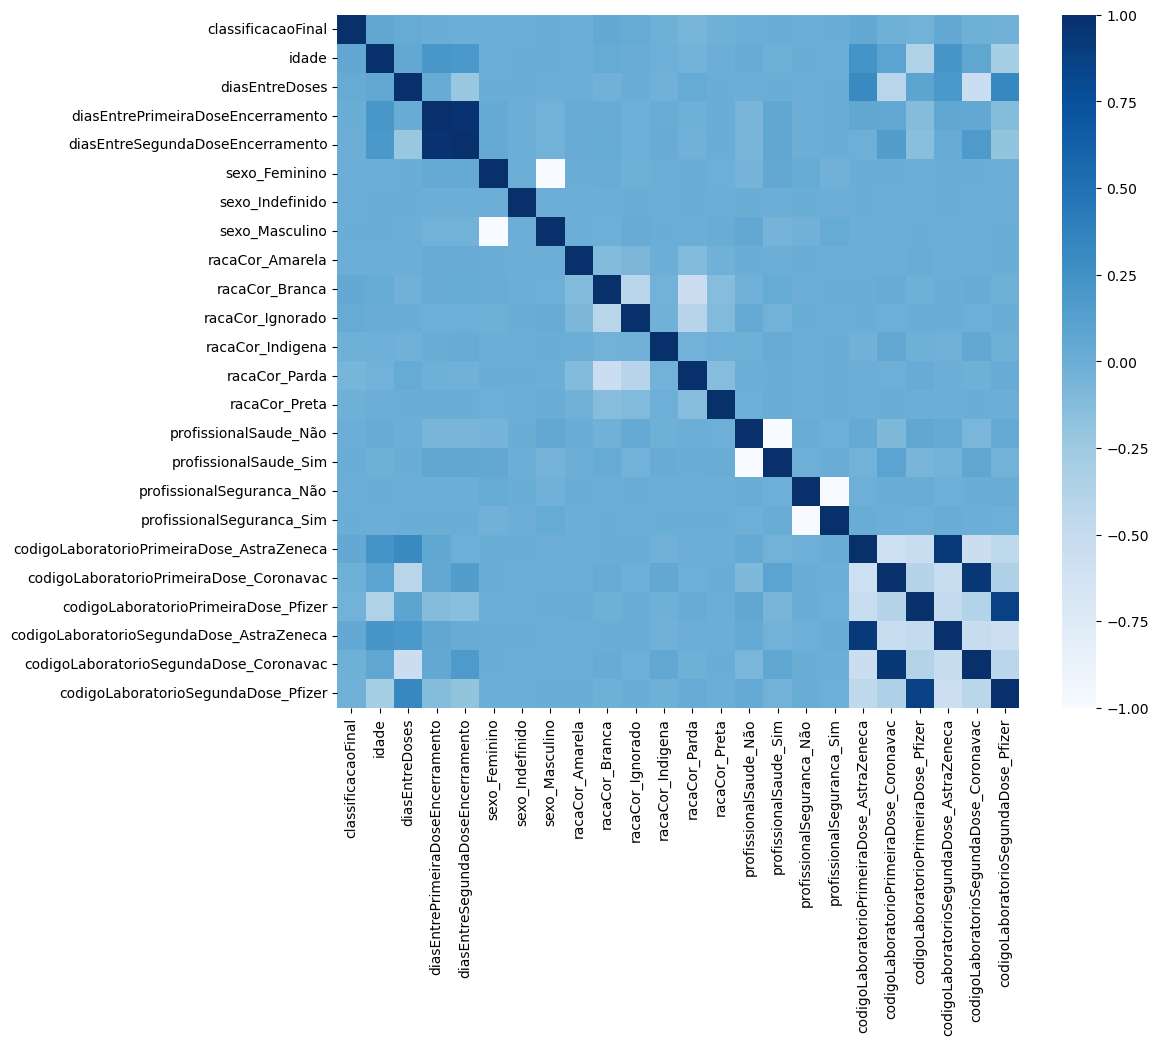

In [7]:
# Pela tabela de correlação, podemos ver que as variáveis ​​não estão muito correlacionadas entre si.

corr = data.corr()
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, cmap='Blues')#, annot=True)
plt.show()

# 5. Machine Learning

### Regressão Logística

In [91]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion)

Accuracy: 0.5394706176865444
Confusion Matrix:
[[568108 553767]
 [485634 649461]]


### Random Forest

In [92]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion)

Accuracy: 0.5349495119562954
Confusion Matrix:
[[594538 527337]
 [522268 612827]]


### Gradient Boosting

In [93]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion)

Accuracy: 0.5706779443235843
Confusion Matrix:
[[652121 469754]
 [499213 635882]]


### SVM

In [9]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion)

### Multilayer Perceptron

In [95]:
nn_model = MLPClassifier()
nn_model.fit(X_train, y_train)
y_pred = nn_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion)

Accuracy: 0.5600969441330633
Confusion Matrix:
[[478792 643083]
 [349765 785330]]


### KNN

In [96]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion)

Accuracy: 0.5352264318976326
Confusion Matrix:
[[599410 522465]
 [526515 608580]]


### CatBoost

In [ ]:
catboost_model = CatBoostClassifier()
catboost_model.fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion)

### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
adaboost_model = AdaBoostClassifier()
adaboost_model.fit(X_train, y_train)
y_pred = adaboost_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion)

# 6. Conclusões

Uma enorme parte do tempo dedicado ao trabalho foi para unir, limpar e uniformizar os registros. Os dados em questão são muito volumosos e muito variados, de forma que é difícil encontrar padrões para realizar previsões. Quase todas as features parecem ter uma correlação muito próxima de $0$ entre si. Alguns algoritmos nem mesmo tiveram tempo de serem rodados, pela demora excessiva de execução. Nota-se que a acurácia se mostrou muito baixa, mas ainda superou a baseline de chute aleatório ($50\%$ de acurácia). Provavelmente, a melhor maneira de melhorar as previsões seria realizando estudos epidemiológicos sobre os dados ou desenvolver/utilizar algoritmos que aprendam segundo as leis epidemiológicas.